In [19]:
# pip install pandas
# pip install seaborn
# pip install matplotlib
# pip install openpyxl

In [20]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [21]:
# Define a class to store file data
class ExecutionResult:
    def __init__(self, file_name, execution_time, script_name, script_num_proc, uuid):
        self.file_name = file_name
        self.execution_time = execution_time
        self.script_name = script_name
        self.script_num_proc = script_num_proc
        self.uuid = uuid

    def __repr__(self):
        return f"ExecutionResult(file_name='{self.file_name}', execution_time={self.execution_time}, script_name='{self.script_name}', script_num_proc={self.script_num_proc}, uuid='{self.uuid}')"

# Function to parse a single file
def parse_file(file_path):
    execution_time = None
    file_name = Path(file_path).name
    # Extract the script_name, script_num_proc, and uuid from the file name
    pattern = r"^(prompt-inicial|prompt-modificado|prompt-com-scatter|sequencial)-([1248])-([a-fA-F0-9\-]+)\.txt$"
    match = re.fullmatch(pattern, file_name)
    if match:
        script_name = match.group(1)
        script_num_proc = int(match.group(2))
        uuid_val = match.group(3)
    else:
        print(f"Warning: Filename format is incorrect for {file_name}")
        return None

    with open(file_path, 'r') as file:
        for line in file:
            # Look for the execution time line
            match = re.match(r"Tempo de Execução:\s*(\d+\.\d+)", line)
            if match:
                execution_time = float(match.group(1))
                break

    if execution_time is not None:
        return ExecutionResult(file_name, execution_time, script_name, script_num_proc, uuid_val)
    else:
        print(f"Warning: Execution time not found in file {file_name}")
        return None

# Function to read all files in the "runs" directory
def parse_runs_directory(base_dir, scripts):
    results = []
    if not os.path.exists(base_dir):
        print(f"Error: Directory {base_dir} does not exist.")
        return results

    print(f"Looking in directory: {base_dir}")

    # List files in base directory
    files_in_directory = [file for file in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, file))]
    if not files_in_directory:
        print("The directory is empty or contains no files.")

    # Walk through the directory
    for root, dirs, files in os.walk(base_dir):
        print(f"Root: {root}, Files: {files}")  # Debug: see what files are found
        for file in files:
            file_path = os.path.join(root, file)
            result = parse_file(file_path)
            if result and result.script_name in scripts:
                results.append(result)
    return results

# Main script
def main():
    runs_directory = "runs/"  # Path to runs folder
    scripts = ['prompt-inicial', 'prompt-modificado', 'prompt-com-scatter', 'sequencial']  # List of scripts to process

    # Parse files in the "runs" directory
    results = parse_runs_directory(runs_directory, scripts)

    return results

In [22]:
# Parse files in the "runs" directory
results = main()

# Prepare the data for the DataFrame
data = {
    'file_name': [],
    'script_name': [],
    'execution_time': [],
    'uuid': [],
    'num_proc': []
}

# Populate the data for the DataFrame
for result in results:
    data['file_name'].append(result.file_name)
    data['script_name'].append(result.script_name)
    data['execution_time'].append(result.execution_time)
    data['uuid'].append(result.uuid)
    data['num_proc'].append(result.script_num_proc)

# Create a DataFramea
df = pd.DataFrame(data)

# Save to Excel
excel_name = "input.xlsx"
csv_name = "input.csv"
df.to_excel(excel_name, index=False)
df.to_csv(csv_name, index=False)

# Add SpeedUp and Efficiency columns
base_times = df[df["num_proc"] == 1][["script_name", "execution_time"]].rename(
    columns={"execution_time": "base_time"}
)
df = df.merge(base_times, on="script_name", how="left")
df["speedup"] = df["base_time"] / df["execution_time"]
df["efficiency"] = df["speedup"] / df["num_proc"]  * 100
df.loc[df["num_proc"] == 1, ["speedup", "efficiency"]] = None  # Set None for num_proc = 1

# # Adjust time scale
time_scale_factor = 1e6  # Convert seconds to microseconds
df['execution_time'] *= time_scale_factor
df['base_time'] *= time_scale_factor

# Calculate distinct execution count (uuid) per script_name
execution_counts = df.groupby("script_name")["uuid"].nunique().reset_index()
execution_counts["execution_count"] = execution_counts["uuid"]
df = df.merge(execution_counts[["script_name", "execution_count"]], on="script_name", how="left")

Looking in directory: runs/
Root: runs/, Files: ['prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b0f1163561ff.txt', 'prompt-inicial-2-8d3febb5-0caf-4a2f-8450-39f9bcdb1118.txt', 'prompt-modificado-4-34b44481-c32b-45e7-abd7-def73ad1ffa8.txt', 'prompt-modificado-1-b108dd16-8726-43ad-8b82-8e5bcb6bc394.txt', 'prompt-inicial-2-fb97bca7-b536-4a7d-807d-b0f1163561ff.txt', 'prompt-inicial-8-820cf9ba-7d55-440e-bed9-3784a43d470c.txt', 'prompt-com-scatter-8-5bc2551a-53ad-4062-a1b5-e6eba6ba0ef7.txt', 'prompt-inicial-4-ef4b9a15-af23-4a74-a606-1c7f6323a455.txt', 'prompt-inicial-1-07b114bd-fec1-4cb1-baf9-c64ced072240.txt', 'prompt-com-scatter-8-122f613d-1e3d-4977-aab8-0d4e35a1df27.txt', 'prompt-inicial-2-34b44481-c32b-45e7-abd7-def73ad1ffa8.txt', 'prompt-modificado-1-fb97bca7-b536-4a7d-807d-b0f1163561ff.txt', 'prompt-com-scatter-8-0973361a-a24e-4dc1-a839-ecc219efd571.txt', 'prompt-modificado-1-8d3febb5-0caf-4a2f-8450-39f9bcdb1118.txt', 'prompt-inicial-1-ef4b9a15-af23-4a74-a606-1c7f6323a455.txt', 'sequenc

In [23]:
df

,file_name,script_name,execution_time,uuid,num_proc,base_time,speedup,efficiency,execution_count
0,prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b...,prompt-com-scatter,103854.0,fb97bca7-b536-4a7d-807d-b0f1163561ff,1,103854.0,NaN,NaN,10
1,prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b...,prompt-com-scatter,103854.0,fb97bca7-b536-4a7d-807d-b0f1163561ff,1,108286.0,NaN,NaN,10
2,prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b...,prompt-com-scatter,103854.0,fb97bca7-b536-4a7d-807d-b0f1163561ff,1,105979.0,NaN,NaN,10
3,prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b...,prompt-com-scatter,103854.0,fb97bca7-b536-4a7d-807d-b0f1163561ff,1,107868.0,NaN,NaN,10
4,prompt-com-scatter-1-fb97bca7-b536-4a7d-807d-b...,prompt-com-scatter,103854.0,fb97bca7-b536-4a7d-807d-b0f1163561ff,1,113122.0,NaN,NaN,10
...,...,...,...,...,...,...,...,...,...
1295,prompt-modificado-4-ef4b9a15-af23-4a74-a606-1c...,prompt-modificado,59674.0,ef4b9a15-af23-4a74-a606-1c7f6323a455,4,73514.0,1.231927,30.798170,10
1296,prompt-modificado-4-ef4b9a15-af23-4a74-a606-1c...,prompt-modificado,59674.0,ef4b9a15-af23-4a74-a606-1c7f6323a455,4,74675.0,1.251383,31.284563,10
1297,prompt-modificado-4-ef4b9a15-af23-4a74-a606-1c...,prompt-modificado,59674.0,ef4b9a15-af23-4a74-a606-1c7f6323a455,4,73885.0,1.238144,30.953598,10
1298,prompt-modificado-4-ef4b9a15-af23-4a74-a606-1c...,prompt-modificado,59674.0,ef4b9a15-af23-4a74-a606-1c7f6323a455,4,74748.0,1.252606,31.315146,10


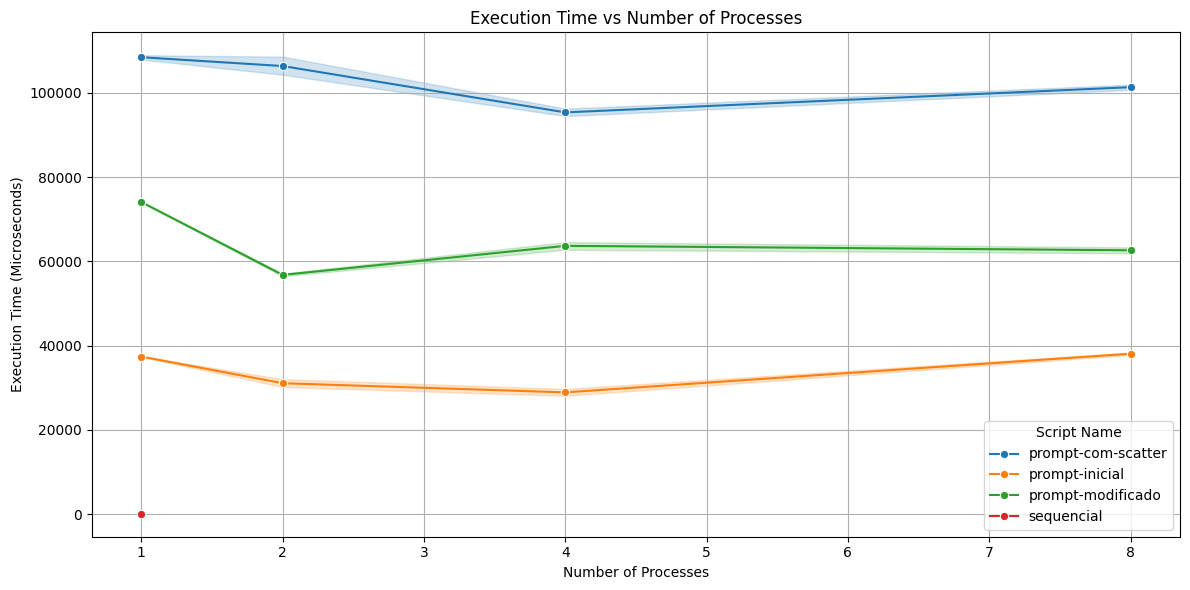

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="num_proc", y="execution_time", hue="script_name", marker="o")
plt.title("Execution Time vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Execution Time (Microseconds)")
plt.legend(title="Script Name")
plt.grid(True)
plt.tight_layout()
plt.show()


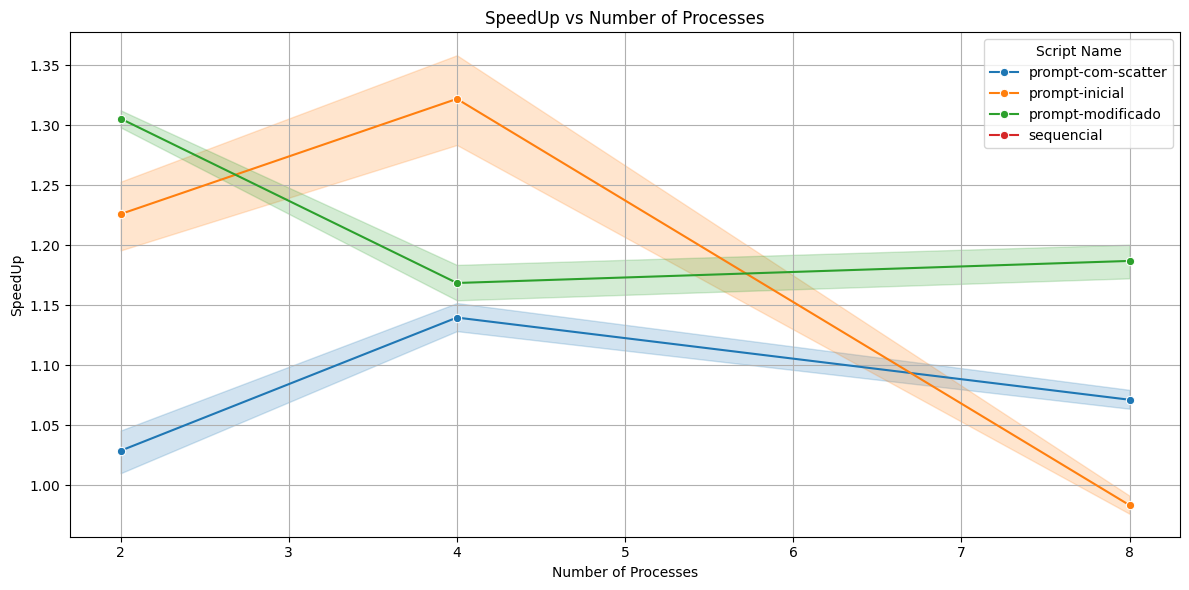

In [25]:
# Plot 2: SpeedUp
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="num_proc", y="speedup", hue="script_name", marker="o")
plt.title("SpeedUp vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("SpeedUp")
plt.legend(title="Script Name")
plt.grid(True)
plt.tight_layout()
plt.show()

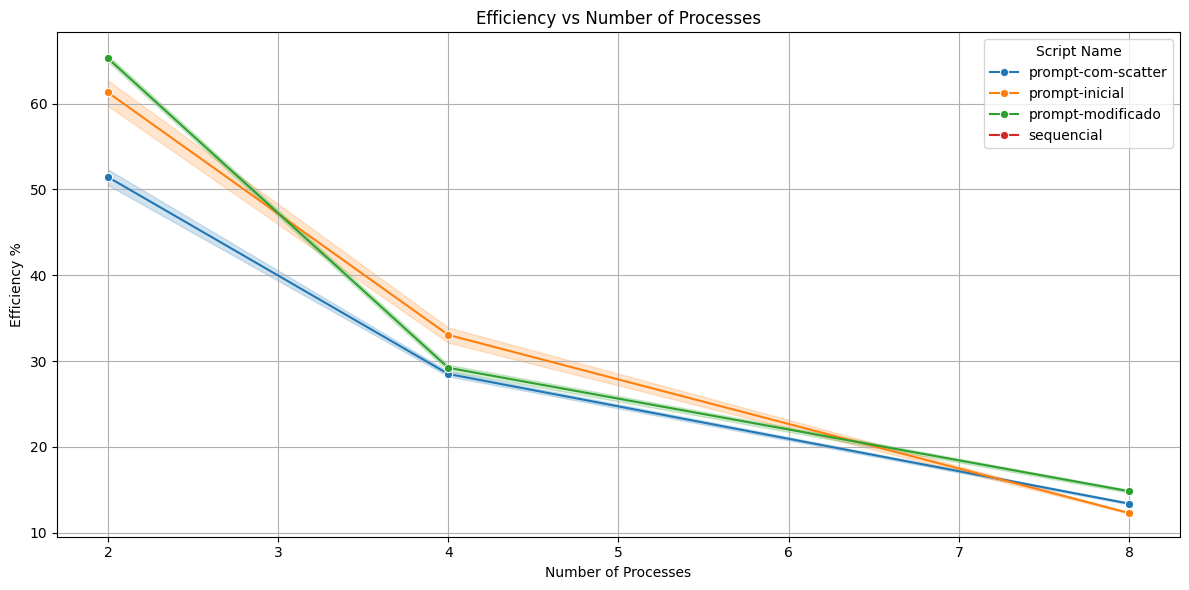

In [26]:
# Plot 3: Efficiency
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="num_proc", y="efficiency", hue="script_name", marker="o")
plt.title("Efficiency vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Efficiency %")
plt.legend(title="Script Name")
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Save to Excel
excel_name = "results.xlsx"
csv_name = "results.csv"
df.to_excel(excel_name, index=False)
df.to_csv(csv_name, index=False)